Начинаю сохранять поделки. Небольшое начало - восстановление ошибки от наивной ESP модели с дефолтными параметрами.

Для этого должен существовать такой файл `data/{well}/restore_input_/{well}_restore_input.csv`

# Продемонстрирую запуск этого "Процессора"

В текущей директории запускаем `Error_prediction_explainer_py.py`, с него гораздо удобней запускать чем в тетрадке

в папке с 'restore' появилась новая папка для мультипроцессинга. Сошьем это всё

In [51]:
import os
import pandas as pd
import preprocessor as prep
import numpy as np

from Error_prediction import MLPrepro
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt

In [36]:
well = 252
multiprocessing_on = True
if multiprocessing_on == True:
    filenames_list = []
    for (dirpath, dirnames, filenames) in os.walk(f'data/{well}/restore_/multiprocessing__err_prediction'):
        filenames_list.extend(filenames)
        break
    print(filenames_list)
    for i,j in enumerate(filenames_list):
        if i == 0:
            first_result_data = pd.read_csv(f'data/{well}/restore_/multiprocessing__err_prediction/{j}',
                                            parse_dates = True, index_col = 'Время')
        else:
            another_result_data = pd.read_csv(f'data/{well}/restore_/multiprocessing__err_prediction/{j}',
                                              parse_dates = True, index_col = 'Время')
            first_result_data = first_result_data.append(another_result_data, sort = True)
            del first_result_data['d']
            first_result_data = first_result_data.dropna(subset = ['ESP.ESPpump.EffiencyESP_d'])
    first_result_data.to_csv(f'data/{well_name}/restore_/{well_name}_restore_1_error_pred.csv')

['252_restore_0.csv', '252_restore_1.csv', '252_restore_2.csv', '252_restore_3.csv', '252_restore_4.csv', '252_restore_5.csv', '252_restore_6.csv', '252_restore_7.csv']


Теперь есть `{well}_restore_1_error_pred`, им мы и будем пользоваться

In [37]:
calculated_data = prep.load_calculated_data_from_csv(f'data/{well}/restore_/{well}_restore_1_error_pred.csv')
input_data = pd.read_csv(f'data/{well_name}/restore_input_/{well_name}_restore_input.csv',
                         parse_dates=True, index_col = 'Время')
all_data = input_data.join(calculated_data, how = 'outer')
all_data.to_csv(f'data/{well}/restore_/{well}_calc_and_input.csv')
all_data.sort_index(inplace=True)

# Теперь настраиваем регрессию на ошибку

In [38]:
x = all_data[['ГФ (СУ)',
              'Процент обводненности (СУ)',
              'Давление на приеме насоса (пласт. жидкость) (СУ)',
              'Рбуф (Ш)', 'Температура на приеме насоса (пласт. жидкость) (СУ)',
              'F вращ ТМ (Ш)', 'Dшт (Ш)',
              'Активная мощность (СУ)',
              'Напряжение на выходе ТМПН (СУ)',
              'Коэффициент мощности (СУ)',
              'Объемный дебит жидкости (СУ)',
              'Q ж, м3/сут (Модель)',
              'F вращ ТМ (Ш)'
             ]
            ].copy()


print(f'number of NaN values: {np.isnan(x.values).sum()}/{x.shape[0]}')
x.dropna(inplace=True)
data = x.dropna()

y = pd.Series(x['Объемный дебит жидкости (СУ)'].values - x['Q ж, м3/сут (Модель)'].values)
x.drop(columns=['Объемный дебит жидкости (СУ)', 'Q ж, м3/сут (Модель)'], inplace=True)

number of NaN values: 0/143


Разобьём данные на тестовые и для обучения

In [39]:
date_col = x.index
x.reset_index(drop=True, inplace=True)

x_train, x_test, y_train, y_test = MLPrepro.get_test_train_drop_2_points(x, y)

Масштабируем данные

In [41]:
y_test = y_test.values.reshape((-1, 1))
y_train = y_train.values.reshape((-1, 1))

sc_x = StandardScaler()
sc_x.fit(x_train)

sc_y = StandardScaler()
sc_y.fit(y_train)

x_train_sc = sc_x.transform(x_train)
x_test_sc = sc_x.transform(x_test)

y_train_sc = sc_y.transform(y_train)
y_test_sc = sc_y.transform(y_test)

Подбираем параметр регуляризатора

In [46]:
parameters = {'alpha': np.linspace(1e-7, 30, 1000)}

r_est = linear_model.Ridge()
gs_cv = GridSearchCV(r_est, parameters, cv=7)
_ = gs_cv.fit(x_train_sc, y_train_sc)
b_r_est = gs_cv.best_estimator_
predicted_err = sc_y.inverse_transform(b_r_est.predict(sc_x.transform(x)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


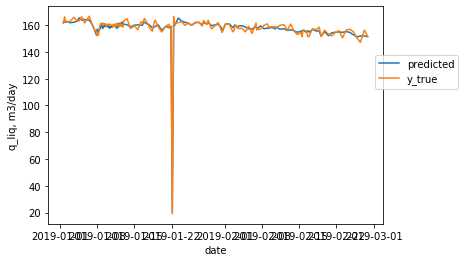

In [49]:
plt.plot(date_col, predicted_err[:, 0] + data['Q ж, м3/сут (Модель)'].values, label='predicted')
plt.plot(date_col, data['Объемный дебит жидкости (СУ)'], label='y_true')
plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.8))
plt.xlabel('date')
plt.ylabel('q_liq, m3/day')
plt.show()

In [54]:
err = metrics.mean_absolute_error(predicted_err[:, 0] + data["Q ж, м3/сут (Модель)"].values,
                                  data["Объемный дебит жидкости (СУ)"])
print(f'MAE_score in saled data: {err}')
print(f'MAE_score as %:          {err/data["Объемный дебит жидкости (СУ)"].mean() * 100}')

MAE_score in saled data: 1.767359386248381
MAE_score as %:          1.1184625104172972
